# Branches

In [1]:
# include common code and config
%run PIQM_Bootstrap.ipynb

{'pi': 'PI10', 'id': 10, 'start': '2021-03-17T00:00:00Z', 'started': '2021-03-17', 'finish': '2021-06-15T23:59:59Z'}


In [2]:
first_br_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "project_branches")
  |> filter(fn: (r) => r.isstale == "0")
  |> filter(fn: (r) => r.default == "0")  
  |> filter(fn: (r) => r.merged == "1")  
  |> drop(columns:["_measurement", "_field", "isstale", "default", "merged", "mr"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

template_br_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "project_branches")
  |> filter(fn: (r) => r.isstale == "0")
  |> filter(fn: (r) => r.default == "0")  
  |> filter(fn: (r) => r.merged == "1")  
  |> drop(columns:["_measurement", "_field", "isstale", "default", "merged", "mr"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_br_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
    query.append(template_br_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

brs = query_api.query_data_frame(query)
# brs = brs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
brs['ID'] = brs['ID'].astype(int)
brs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
brs

result table                    _start                     _stop  \
59     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
115    mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
71     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
225    mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
81     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
..     ...   ...                       ...                       ...   
39     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
4      mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
27     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
6      mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
42     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   

                        _time      _value                          branch_id  \
59  2021-03-19 15:56:00+00:00  37499485.0                     AT2-364_fix_CI   
115 2021-03-24 09:34:58+00:00  37090127.0                                ddc   
71  2021-03-24 14:59:34+00:00  37071076.0  AT5-395_TmCspSubarrayLeadNode_Fix   
225 2021-03-24 15:28:41+00:00  37070328.0                          submodule   
81  2021-03-24 17:34:38+00:00  37061695.0                           FlaskApp   
..                        ...         ...                                ...   
39  2021-05-19 08:57:08+00:00    631442.0                      update-charts   
4   2021-05-21 10:06:41+00:00    454457.0                 abort-scan-example   
27  2021-05-24 14:35:49+00:00    180104.0       marvin-quarantine-1288963247   
6   2021-05-25 07:23:55+00:00    120039.0                           accuracy   
42  2021-05-25 13:16:18+00:00     97938.0             variable-models-update   

    jira                                   project project_id  \
59     1          ska-telescope/web-maxiv-tangogql   15124978   
115    0                     ska-telescope/pyfabil   17606533   
71     1                 ska-telescope/mid-cbf-mcs   12488466   
225    0    ska-telescope/sdi/cluster-elasticstack   17647962   
81     0                      ska-telescope/stupid   14654456   
..   ...                                       ...        ...   
39     0          ska-telescope/ska-testing-runway   21173098   
4      0          ska-telescope/ska-testing-runway   21173098   
27     1               ska-telescope/tango-example    9673989   
6      0  ska-telescope/sdp/ska-gridder-nifty-cuda   26352726   
42     0              ska-telescope/dashboard-repo   15113915   

                                   ref  ID                 PI  
59                      AT2-364_fix_CI   6   PI6 (2020-03-16)  
115                                ddc   6   PI6 (2020-03-16)  
71   AT5-395_TmCspSubarrayLeadNode_Fix   6   PI6 (2020-03-16)  
225                          submodule   6   PI6 (2020-03-16)  
81                            FlaskApp   6   PI6 (2020-03-16)  
..                                 ...  ..                ...  
39                       update-charts  10  PI10 (2021-03-17)  
4                   abort-scan-example  10  PI10 (2021-03-17)  
27        marvin-quarantine-1288963247  10  PI10 (2021-03-17)  
6                             accuracy  10  PI10 (2021-03-17)  
42              variable-models-update  10  PI10 (2021-03-17)  

[236 rows x 13 columns]

In [3]:

first_mr_trace = """
{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

template_mr_trace = """
time1{0[pi]} = uint(v: {0[start]})
time2{0[pi]} = uint(v: {0[current_start]})
dur{0[pi]} = duration(v: time2{0[pi]} - time1{0[pi]})

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
  |> timeShift(duration: dur{0[pi]}, columns: ["_start", "_stop", "_time"])
"""

# output all the series in reverse order
pis = the_pis.copy()
current = pis.pop(-1)
pi_list = ([current] + pis[: (selected_pi - select_pis) : -1])[::-1]
query = [first_mr_trace.format(current)]
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pis[: (selected_pi - select_pis) : -1]:
    pi["current_start"] = last_start
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

mrs = query_api.query_data_frame(query)
# mrs = mrs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
mrs['ID'] = mrs['ID'].astype(int)
mrs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
mrs

result table                    _start                     _stop  \
2636    mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
2242    mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
949     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
950     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
953     mrs     0 2021-03-17 00:00:00+00:00 2021-06-16 23:59:59+00:00   
...     ...   ...                       ...                       ...   
706     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
451     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
657     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
456     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
471     mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   

                                _time      _value         author  \
2636 2021-03-18 01:23:23.504000+00:00  37641217.0  sorgenskammer   
2242 2021-03-19 04:43:35.437000+00:00  37547915.0   piersharding   
949  2021-03-19 10:59:43.535000+00:00  37523145.0         adb-42   
950  2021-03-19 10:59:43.535000+00:00  37520306.0         adb-42   
953  2021-03-19 10:59:43.535000+00:00  37523079.0         adb-42   
...                               ...         ...            ...   
706  2021-05-26 16:08:55.939000+00:00    110554.0    timcornwell   
451  2021-05-26 16:35:08.065000+00:00      9059.0     majashdown   
657  2021-05-26 16:38:51.192000+00:00       606.0          scpmw   
456  2021-05-26 17:00:16.756000+00:00       728.0      marvin-42   
471  2021-05-26 17:11:31.805000+00:00     33980.0     matteo1981   

           authorname branch_jira jira      merged_by      mr_id  \
2636    Adam Campbell           0    0  sorgenskammer   52726216   
2242    Piers Harding           1    1         aensor   52844271   
949   Adriaan de Beer           0    0         adb-42   52877318   
950   Adriaan de Beer           0    0         adb-42   54040021   
953   Adriaan de Beer           0    0         adb-42   59415564   
...               ...         ...  ...            ...        ...   
706      Tim Cornwell           1    1    timcornwell  101336086   
451      Mark Ashdown           1    1        unknown  101561169   
657    Peter Wortmann           1    1          scpmw  101578436   
456            Marvin           1    1        unknown  101579550   
471   Matteo Di Carlo           1    1     matteo1981  101488934   

                                          project project_id  \
2636       ska-telescope/sdp/sep_pipeline_imaging   15088717   
2242            ska-telescope/rdma-data-transport   16444104   
949   ska-telescope/templates/ska-python-skeleton    9070627   
950              ska-telescope/csp-lmc-subelement   17807228   
953      ska-telescope/sdc/sdc-submission-service   18934144   
...                                           ...        ...   
706                 ska-telescope/external/rascil   19308749   
451         ska-telescope/sdp/ska-sdp-integration   21141217   
657                          ska-telescope/skampi   11448712   
456                   ska-telescope/tango-example    9673989   
471             ska-telescope/sdi/ska-cicd-celery   26389323   

                                ref stale   state  ID                 PI  
2636                            k8s     0  merged   6   PI6 (2020-03-16)  
2242       st-335-dockerise-receive     0  merged   6   PI6 (2020-03-16)  
949                  fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
950                  fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
953                  fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
...                             ...   ...     ...  ..                ...  
706   sim-866_minimize_restore_step     0  merged  10  PI10 (2021-03-17)  
451                         sim-888     0  opened  10  PI10 (2021-03-17)  
657                         dppt-23     0  merged 

In [4]:
brs_jira = brs[['ID', 'PI','jira','branch_id']].groupby(['ID', 'PI','jira']).agg(['count', 'size', 'nunique']).reset_index()
# brs_jira.loc[brs_jira.jira == '0', 'jira'] = 'no'
# brs_jira.loc[brs_jira.jira == '1', 'jira'] = 'yes'
brs_jira.sort_values(by=['ID', 'jira'], ascending=[True, False], inplace=True)
brs_jira[brs_jira.jira == '0']
# brs_jira.loc[brs_jira.jira == '0', 'text'] = (brs_jira[brs_jira.jira == '1'].branch_id / (brs_jira[brs_jira.jira == '1'].branch_id + brs_jira[brs_jira.jira == '0'].branch_id))
# (brs_jira[brs_jira.jira == '1'].branch_id.reset_index() + 
#       brs_jira[brs_jira.jira == '0'].branch_id.reset_index())

no_jira = brs_jira[brs_jira.jira == '0'].reset_index()
# no_jira['percent'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] / (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count']))
# (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
#       brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])

no_jira['total'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
      brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])

no_jira['percent'] = (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] / 
     (brs_jira[brs_jira.jira == '1'].reset_index().branch_id['count'] + 
      brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count'])) * 100
# brs_jira
no_jira
# brs_jira[brs_jira.jira == '0'].reset_index().branch_id['count']

index  ID                 PI jira branch_id              total    percent
                                        count size nunique                 
0     0   6   PI6 (2020-03-16)    0        19   19      19    36  47.222222
1     2   7   PI7 (2020-06-16)    0        10   10      10    19  47.368421
2     4   8   PI8 (2020-09-16)    0        20   20      20    61  67.213115
3     6   9   PI9 (2020-12-17)    0        25   25      25    77  67.532468
4     8  10  PI10 (2021-03-17)    0        19   19      19    43  55.813953

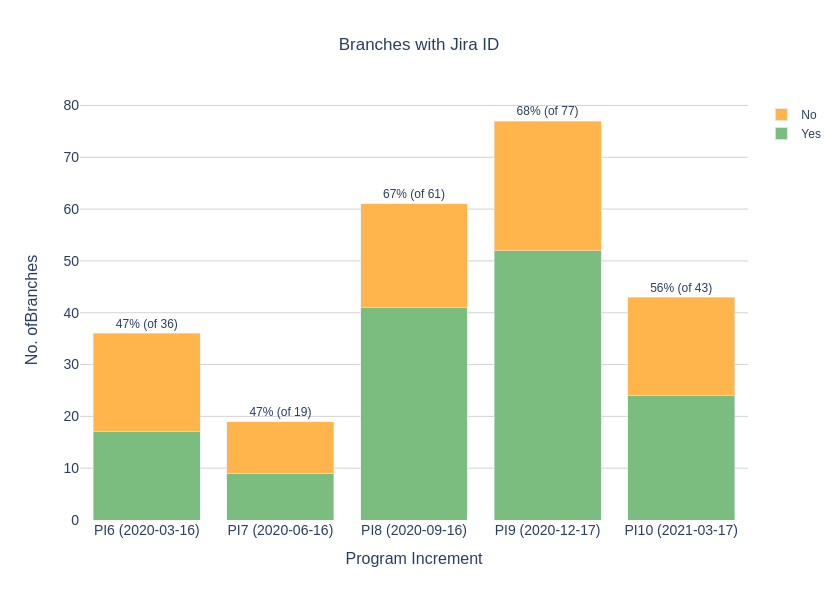

In [5]:
import plotly.graph_objects as go
stack_labels = ['{:.0f}% (of {:.0f})'.format(x, y) for x, y in zip(no_jira['percent'], no_jira['total'])]
fig = go.Figure(go.Bar(x=brs_jira.PI.unique(), y=brs_jira[brs_jira.jira == '1'].branch_id['count'], name='Yes',
    marker_color='#7ABD7E'))
fig.add_trace(go.Bar(x=brs_jira.PI.unique(), y=brs_jira[brs_jira.jira == '0'].branch_id['count'], name='No',
    marker_color='#FFB54C', text=stack_labels))
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_traces(text=brs_jira.PI.unique(), textposition='outside')
fig.update_traces( textposition='outside')
fig.update_layout(barmode='stack', yaxis=dict(
        title='No. ofBranches',
        titlefont_size=16,
        tickfont_size=14,
    ), xaxis=dict(
        title='Program Increment',
        titlefont_size=16,
        tickfont_size=14,
    ), height=600, title='Branches with Jira ID', title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()


In [6]:

template_mr_trace = """

{0[pi]} = from(bucket: "gitlab_metrics")
  |> range(start: {0[start]}, stop: {0[finish]})
  |> filter(fn: (r) => r._measurement == "merge_requests")
  |> drop(columns:["_measurement", "_field"])
  |> sort(columns: ["dateTime"], desc: false)
  |> set(key: "ID",value: "{0[id]}")
  |> set(key: "PI",value: "{0[pi]} ({0[started]})")
"""

# output all the series in reverse order
query = []
tables = ", ".join([pi["pi"] for pi in pi_list])
for pi in pi_list:
#     pi["current_start"] = last_start
    query.append(template_mr_trace.format(pi))
query.append("""
union(tables: [{}])
  |> group()
  |> yield(name: "mrs")
""".format(
        tables
    )
)
query = "\n".join(query)

# print(query)

query_api = client.query_api()

mrs = query_api.query_data_frame(query)
# mrs = mrs[["_value", "_field"]]\
#     .rename(columns={"_value": "Merge Requests", "_field": "PI"})
mrs['ID'] = mrs['ID'].astype(int)
mrs['branch_jira'] = mrs['branch_jira'].astype(int)
mrs.sort_values(by=['ID', '_time'], ascending=[True, True], inplace=True)
mrs

result table                    _start                     _stop  \
349     mrs     0 2020-03-16 00:00:00+00:00 2020-06-15 23:59:59+00:00   
288     mrs     0 2020-03-16 00:00:00+00:00 2020-06-15 23:59:59+00:00   
38      mrs     0 2020-03-16 00:00:00+00:00 2020-06-15 23:59:59+00:00   
39      mrs     0 2020-03-16 00:00:00+00:00 2020-06-15 23:59:59+00:00   
42      mrs     0 2020-03-16 00:00:00+00:00 2020-06-15 23:59:59+00:00   
...     ...   ...                       ...                       ...   
2811    mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
2556    mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
2762    mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
2561    mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   
2576    mrs     0 2021-03-17 00:00:00+00:00 2021-06-15 23:59:59+00:00   

                                _time      _value         author  \
349  2020-03-17 01:23:23.504000+00:00  37641217.0  sorgenskammer   
288  2020-03-18 04:43:35.437000+00:00  37547915.0   piersharding   
38   2020-03-18 10:59:43.535000+00:00  37523145.0         adb-42   
39   2020-03-18 10:59:43.535000+00:00  37520306.0         adb-42   
42   2020-03-18 10:59:43.535000+00:00  37523079.0         adb-42   
...                               ...         ...            ...   
2811 2021-05-26 16:08:55.939000+00:00    110554.0    timcornwell   
2556 2021-05-26 16:35:08.065000+00:00      9059.0     majashdown   
2762 2021-05-26 16:38:51.192000+00:00       606.0          scpmw   
2561 2021-05-26 17:00:16.756000+00:00       728.0      marvin-42   
2576 2021-05-26 17:11:31.805000+00:00     33980.0     matteo1981   

           authorname  branch_jira jira      merged_by      mr_id  \
349     Adam Campbell            0    0  sorgenskammer   52726216   
288     Piers Harding            1    1         aensor   52844271   
38    Adriaan de Beer            0    0         adb-42   52877318   
39    Adriaan de Beer            0    0         adb-42   54040021   
42    Adriaan de Beer            0    0         adb-42   59415564   
...               ...          ...  ...            ...        ...   
2811     Tim Cornwell            1    1    timcornwell  101336086   
2556     Mark Ashdown            1    1        unknown  101561169   
2762   Peter Wortmann            1    1          scpmw  101578436   
2561           Marvin            1    1        unknown  101579550   
2576  Matteo Di Carlo            1    1     matteo1981  101488934   

                                          project project_id  \
349        ska-telescope/sdp/sep_pipeline_imaging   15088717   
288             ska-telescope/rdma-data-transport   16444104   
38    ska-telescope/templates/ska-python-skeleton    9070627   
39               ska-telescope/csp-lmc-subelement   17807228   
42       ska-telescope/sdc/sdc-submission-service   18934144   
...                                           ...        ...   
2811                ska-telescope/external/rascil   19308749   
2556        ska-telescope/sdp/ska-sdp-integration   21141217   
2762                         ska-telescope/skampi   11448712   
2561                  ska-telescope/tango-example    9673989   
2576            ska-telescope/sdi/ska-cicd-celery   26389323   

                                ref stale   state  ID                 PI  
349                             k8s     0  merged   6   PI6 (2020-03-16)  
288        st-335-dockerise-receive     0  merged   6   PI6 (2020-03-16)  
38                   fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
39                   fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
42                   fix/remove-pip     0  merged   6   PI6 (2020-03-16)  
...                             ...   ...     ...  ..                ...  
2811  sim-866_minimize_restore_step     0  merged  10  PI10 (2021-03-17)  
2556                        sim-888     0  opened  10  PI10 (2021-03-17)  
2762                        dppt-23   

In [7]:
mrs_branch_jira = mrs[mrs.stale=='0'][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
mrs_branch_jira

ID                 PI branch_jira mr_id             
                                     count size nunique
0   6   PI6 (2020-03-16)           0   165  165     165
1   6   PI6 (2020-03-16)           1   175  175     175
2   7   PI7 (2020-06-16)           0   141  141     141
3   7   PI7 (2020-06-16)           1   204  204     204
4   8   PI8 (2020-09-16)           0   158  158     158
5   8   PI8 (2020-09-16)           1   386  386     386
6   9   PI9 (2020-12-17)           0   258  258     258
7   9   PI9 (2020-12-17)           1   544  544     544
8  10  PI10 (2021-03-17)           0    96   96      96
9  10  PI10 (2021-03-17)           1   635  635     635

In [8]:
mrs_branch_jira = mrs[mrs.stale=='0'][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
mrs_branch_jira = mrs_branch_jira.sort_values(by=['ID', 'branch_jira'], ascending=[True, False], inplace=False).reset_index()
no_jira = mrs[(mrs.stale=='0') & (mrs.branch_jira != 1)][['ID', 'PI','branch_jira','mr_id']].groupby(['ID', 'PI','branch_jira']).agg(['count', 'size', 'nunique']).reset_index()
no_jira = no_jira.sort_values(by=['ID', 'branch_jira'], ascending=[True, False], inplace=False).reset_index()
# no_jira['percent'] = (mrs_branch_jira.count / (mrs_branch_jira.count + no_jira.count))
# (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].mr_id.reset_index() + 
#       mrs_branch_jira[mrs_branch_jira.branch_jira == 0].mr_id.reset_index()).mr_id

no_jira['total'] = (mrs_branch_jira.mr_id['count'] + no_jira.mr_id['count'])

no_jira['percent'] = (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].reset_index().mr_id['count'] / 
     (mrs_branch_jira[mrs_branch_jira.branch_jira == 1].reset_index().mr_id['count'] + 
      mrs_branch_jira[mrs_branch_jira.branch_jira == 0].reset_index().mr_id['count'])) * 100
# mrs_branch_jira
no_jira


index  ID                 PI branch_jira mr_id               total  \
                                           count size nunique          
0     0   6   PI6 (2020-03-16)           0   165  165     165  340.0   
1     1   7   PI7 (2020-06-16)           0   141  141     141  306.0   
2     2   8   PI8 (2020-09-16)           0   158  158     158  362.0   
3     3   9   PI9 (2020-12-17)           0   258  258     258  399.0   
4     4  10  PI10 (2021-03-17)           0    96   96      96  482.0   

     percent  
              
0  51.470588  
1  59.130435  
2  70.955882  
3  67.830424  
4  86.867305

In [9]:
mrs[mrs.branch_jira == 0][['author', 'project', 'ref', 'stale', 'jira', 'branch_jira', 'ID']]

author                                      project  \
349     sorgenskammer       ska-telescope/sdp/sep_pipeline_imaging   
38             adb-42  ska-telescope/templates/ska-python-skeleton   
39             adb-42             ska-telescope/csp-lmc-subelement   
42             adb-42     ska-telescope/sdc/sdc-submission-service   
44             adb-42                    ska-telescope/sdi/bifrost   
...               ...                                          ...   
2790    sorgenskammer     ska-telescope/sdp/ska-gridder-nifty-cuda   
2791    sorgenskammer     ska-telescope/sdp/ska-gridder-nifty-cuda   
2267          calgray          ska-telescope/icrar-leap-accelerate   
2792    sorgenskammer     ska-telescope/sdp/ska-gridder-nifty-cuda   
2131  GianlucaMarotta                ska-telescope/ska-csp-lmc-low   

                            ref stale jira  branch_jira  ID  
349                         k8s     0    0            0   6  
38               fix/remove-pip     0    0            0   6  
39               fix/remove-pip     0    0            0   6  
42               fix/remove-pip     0    0            0   6  
44               fix/remove-pip     0    0            0   6  
...                         ...   ...  ...          ...  ..  
2790                   accuracy     0    0            0  10  
2791                     merger     0    0            0  10  
2267     cgray_eigen_extensions     0    0            0  10  
2792                     README     0    0            0  10  
2131  fix-init-attribute-values     0    0            0  10  

[877 rows x 7 columns]

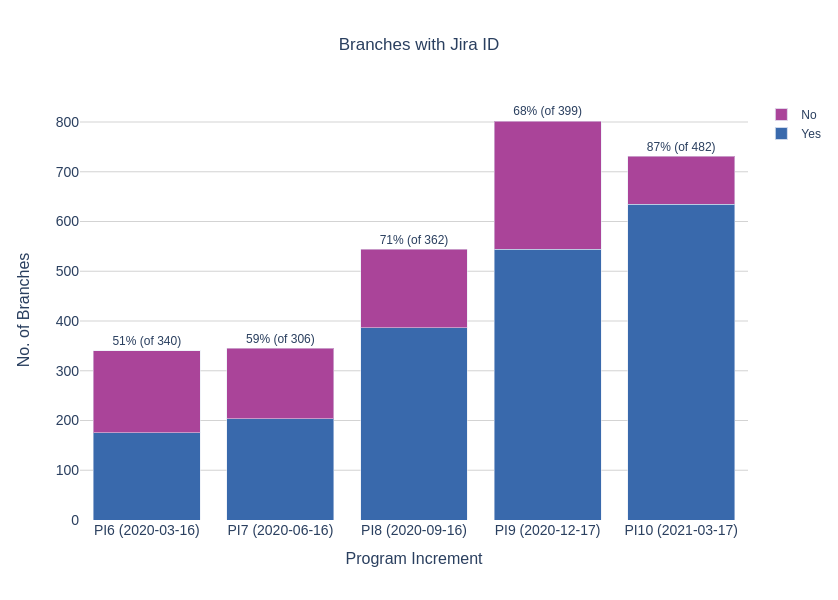

In [10]:
import plotly.graph_objects as go
stack_labels = ['{:.0f}% (of {:.0f})'.format(x, y) for x, y in zip(no_jira['percent'], no_jira['total'])]
fig = go.Figure(go.Bar(x=mrs_branch_jira.PI.unique(), y=mrs_branch_jira[mrs_branch_jira.branch_jira == 1].mr_id['count'], name='Yes',
    marker_color='rgb(57, 105, 172)'))
fig.add_trace(go.Bar(x=mrs_branch_jira.PI.unique(), y=mrs_branch_jira[mrs_branch_jira.branch_jira == 0].mr_id['count'], name='No',
    marker_color='rgb(170, 68, 153)', text=stack_labels))
fig.update_xaxes(showgrid=False, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.update_traces(text=mrs_branch_jira.PI.unique(), textposition='outside')
fig.update_traces( textposition='outside')
fig.update_layout(barmode='stack', yaxis=dict(
        title='No. of Branches',
        titlefont_size=16,
        tickfont_size=14,
    ), xaxis=dict(
        title='Program Increment',
        titlefont_size=16,
        tickfont_size=14,
    ), height=600, title='Branches with Jira ID', title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
fig.show()
